# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-xpdl1t5l
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-xpdl1t5l
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 8.39 MiB/s, done.
Resolving deltas: 100% (3/3), done.


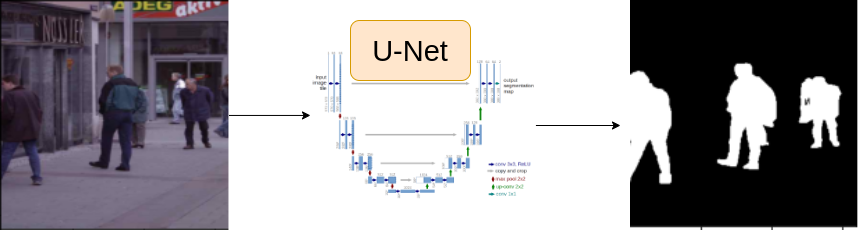

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = 'cuda'
EPOCHS= 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
weights = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

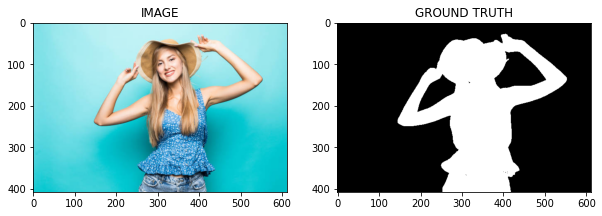

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df , valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
from albumentations.augmentations.transforms import VerticalFlip
def get_train_augs():
  return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
  ])

def get_valid_args():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])


# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
      
      self.df = df
      self.augmentations = augmentations
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)s
    mask = np.expand_dims(mask, axis = -1)
    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #(h, w, c) -> (c, h, w)

      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_args())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


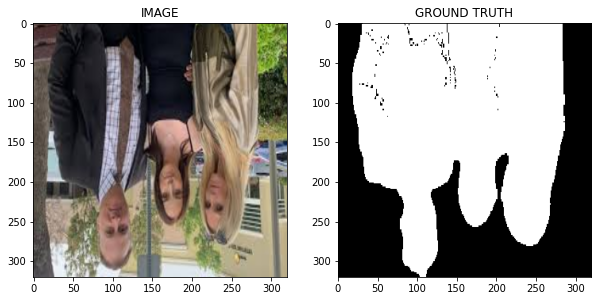

In [16]:
idx = 50
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)


In [19]:
print(f"total no. of batches in trainloader :  {len(trainloader)}")
print(f"total no. of batches in validloader :  {len(validloader)}")

total no. of batches in trainloader :  15
total no. of batches in validloader :  4


In [20]:
for image, mask in trainloader:
  break
print(f"One batch image shape:  {image.shape}")
print(f"One batch mask shape:  {mask.shape}")

One batch image shape:  torch.Size([16, 3, 320, 320])
One batch mask shape:  torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
!pip install -U segmentation-models-pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:

from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [24]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [25]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    return total_loss / len(data_loader)

In [26]:
def eval_fn(data_loader, model):
  model.train()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      
      total_loss += loss.item()
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [27]:
import torch
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [28]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(trainloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVE-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")
  

100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


SAVE-MODEL
Epoch : 1 Train_loss : 0.10127885341644287 Valid_loss : 1.2715688864390056


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


SAVE-MODEL
Epoch : 2 Train_loss : 0.08971427281697592 Valid_loss : 1.1132225513458252


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


SAVE-MODEL
Epoch : 3 Train_loss : 0.07169113159179688 Valid_loss : 0.973676323890686


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


SAVE-MODEL
Epoch : 4 Train_loss : 0.06699072519938151 Valid_loss : 0.892324697971344


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


SAVE-MODEL
Epoch : 5 Train_loss : 0.06011367638905843 Valid_loss : 0.8026442845662435


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


SAVE-MODEL
Epoch : 6 Train_loss : 0.053651833534240724 Valid_loss : 0.6681305646896363


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


SAVE-MODEL
Epoch : 7 Train_loss : 0.04467647473017375 Valid_loss : 0.6313089350859324


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


SAVE-MODEL
Epoch : 8 Train_loss : 0.03724724451700846 Valid_loss : 0.6115041017532349


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


SAVE-MODEL
Epoch : 9 Train_loss : 0.04250964323679606 Valid_loss : 0.5391870319843293


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


SAVE-MODEL
Epoch : 10 Train_loss : 0.03346679210662842 Valid_loss : 0.5101565817991892


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


SAVE-MODEL
Epoch : 11 Train_loss : 0.03567074139912923 Valid_loss : 0.44717568159103394


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


SAVE-MODEL
Epoch : 12 Train_loss : 0.026249245802561442 Valid_loss : 0.44476167956988016


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


SAVE-MODEL
Epoch : 13 Train_loss : 0.025140945116678873 Valid_loss : 0.4086893637975057


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


SAVE-MODEL
Epoch : 14 Train_loss : 0.025573567549387614 Valid_loss : 0.36985790928204854


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


SAVE-MODEL
Epoch : 15 Train_loss : 0.0380972146987915 Valid_loss : 0.3670680741469065


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


Epoch : 16 Train_loss : 0.025688546895980834 Valid_loss : 0.3931418200333913


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Epoch : 17 Train_loss : 0.0243009885152181 Valid_loss : 0.3774861971537272


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


Epoch : 18 Train_loss : 0.024561025698979697 Valid_loss : 0.37067758639653525


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


SAVE-MODEL
Epoch : 19 Train_loss : 0.0245255708694458 Valid_loss : 0.3541214525699615


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


SAVE-MODEL
Epoch : 20 Train_loss : 0.020857783158620198 Valid_loss : 0.3125634014606476


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


Epoch : 21 Train_loss : 0.01794012188911438 Valid_loss : 0.3629737138748169


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


Epoch : 22 Train_loss : 0.019962882995605467 Valid_loss : 0.3294175326824188


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


Epoch : 23 Train_loss : 0.02723784645398458 Valid_loss : 0.3508979837099711


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


Epoch : 24 Train_loss : 0.026695477962493896 Valid_loss : 0.372676811615626


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]

Epoch : 25 Train_loss : 0.030011520783106486 Valid_loss : 0.35269804000854493


# Task 9 : Inference

In [36]:
idx = 2
model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0


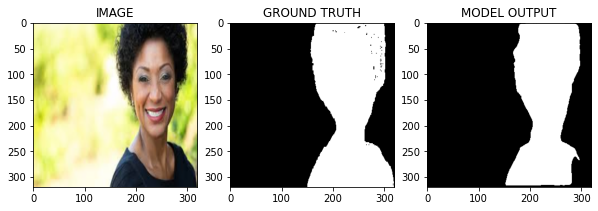

In [37]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya